In [1]:
import numpy as np
from numpy import load
import torch
import torch.nn as nn
import torch.nn.functional as F

from timeit import default_timer as timer


from tensorboardX import SummaryWriter
from datetime import datetime
from source.Data_load import Data_load
from source.Attention_LSTM import RNNModel
from source.train import train_epoch_lstm,evaluate_lstm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mbrnlist1=[(5,194),(2,155),(12,100),(17,29),(42,1),(44,1),(50,92),(2,83),(4,10118),(8,298)]
mbrnlist2=[(5,194),(12,100),(2,155),(17,29),(42,1),(44,1),(2,83),(4,10118),(4,9997),(50,91)]

mbrnlist=mbrnlist1+mbrnlist2
mbrnlist=set(mbrnlist)
mbrnlist=list(mbrnlist)

# load array
MBR_NO,BRN_NO=mbrnlist[2]
featnorm=True

In [4]:
bptt = 39
TGT_VOCAB_SIZE = 3
EMB_SIZE =128
NHEAD = 16
FFN_HID_DIM = 128
BATCH_SIZE = 32
NUM_LAYERS = 6

In [5]:
MBR_NO=42
BRN_NO=1
Val_loss=[]
Train_loss=[]
Accuracy=[]
F1score=[]

if featnorm==True:
    Data_train = load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'norm_train.npy',allow_pickle=True)
    Data_test =  load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'norm_test.npy',allow_pickle=True)
else:
    Data_train = load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'train.npy',allow_pickle=True)
    Data_test =  load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'test.npy',allow_pickle=True)

Xtrain_data,Ytrain_data,Xtest_data,Ytest_data = Data_load(Data_train,Data_test)
torch.manual_seed(0)

SRC_VOCAB_SIZE = Xtrain_data.shape[1]


lstm = RNNModel(rnn_type='LSTM',ntoken=SRC_VOCAB_SIZE,ninp=EMB_SIZE,nhid=FFN_HID_DIM,nlayers=NUM_LAYERS,proj_size=TGT_VOCAB_SIZE,
                attention=False)
summary = SummaryWriter()
for p in lstm.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

lstm = lstm.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

NUM_EPOCHS = 1000
best_val_loss=100000000
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss,_ = train_epoch_lstm(lstm, optimizer,Xtrain_data,Ytrain_data,loss_fn,device,BATCH_SIZE,bptt)
    end_time = timer()
    val_loss,acc,prec,reca,f1sc,confusion = evaluate_lstm(lstm,Xtrain_data,Ytrain_data,loss_fn,device,BATCH_SIZE,bptt)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_confusion=confusion
        best_acc=acc
        best_prec=prec
        best_reca=reca
        best_f1sc=f1sc
        best_model = lstm
    Val_loss.append(val_loss)
    Train_loss.append(train_loss)
    Accuracy.append(acc)
    F1score.append(f1sc)
now = datetime.now()
now.strftime("%m/%d/%Y, %H:%M:%S")

date_time = now.strftime("%m_%d_%Y")

PATH='best_model_lstm_seq_'+date_time+'_'+str(MBR_NO)+'_'+str(BRN_NO)
#     if featnorm==True:
#         torch.save(best_model.state_dict(), PATH+'norm')
#     else:
#         torch.save(best_model.state_dict(), PATH)
if featnorm==True:
    file_name='results/result_ALSTM_'+date_time+'_norm.txt'
else:
    file_name='results/result_ALSTM_'+date_time+'.txt'
text_to_append=PATH+'\t'+"Acc:"+str(best_acc)+'\t'+"prec:"+str(best_prec)+'\t'+"recall:"+str(best_reca)+'\t'+"f1sc:"+str(best_f1sc)
print(text_to_append)
with open(file_name, "a+") as file_object:
    # Move read cursor to the start of file.
    file_object.seek(0)
    # If file is not empty then append '\n'
    data = file_object.read(100)
    if len(data) > 0:
        file_object.write("\n")
    # Append text at the end of file
    file_object.write(text_to_append)

468
468
72960
42337
Acc: 0.5802768640350877
Prec 0.37837993139960807
Recall 0.33710688954444695
F1 0.3565529874382879
468
468
71744
42801
Acc: 0.5965795049063336
Prec 0.19885983496877788
Recall 0.3333333333333333
F1 0.2491073377275307
Epoch: 1, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.856s
468
468
72960
43211
Acc: 0.5922560307017544
Prec 0.19949676823638043
Recall 0.3333333333333333
F1 0.24960647887405302
468
468
71744
42801
Acc: 0.5965795049063336
Prec 0.19885983496877788
Recall 0.3333333333333333
F1 0.2491073377275307
Epoch: 2, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.801s
468
468
72960
43211
Acc: 0.5922560307017544
Prec 0.19949953138778467
Recall 0.3333333333333333
F1 0.24960864165439153
468
468
71744
43210
Acc: 0.6022803300624442
Prec 0.358277522490726
Recall 0.34337048038733337
F1 0.35066564575116277
Epoch: 3, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.797s
468
468
72960
44157
Acc: 0.6052220394736842
Prec 0.4837339456995157
Recall 0.36427992855926566
F1

468
468
71744
47059
Acc: 0.6559294157002676
Prec 0.5260673682435689
Recall 0.49834256925712134
F1 0.5118297944911446
Epoch: 28, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.823s
468
468
72960
47283
Acc: 0.6480674342105263
Prec 0.5216929655910113
Recall 0.4663247123027386
F1 0.4924574277015166
468
468
71744
47256
Acc: 0.6586752899197146
Prec 0.5280130126249124
Recall 0.49845897605572304
F1 0.5128105365162539
Epoch: 29, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.892s
468
468
72960
47222
Acc: 0.6472313596491228
Prec 0.522520600894362
Recall 0.46330220197363464
F1 0.49113277612703027
468
468
71744
47136
Acc: 0.6570026761819804
Prec 0.5251066451803172
Recall 0.4948374036285808
F1 0.5095228688918563
Epoch: 30, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.851s
468
468
72960
46966
Acc: 0.6437225877192982
Prec 0.5129346614334693
Recall 0.46371062321201423
F1 0.4870821684388655
468
468
71744
46898
Acc: 0.653685325602141
Prec 0.5265622833327447
Recall 0.5016001683881295
F1 0.5

468
468
72960
47212
Acc: 0.647094298245614
Prec 0.515682010227991
Recall 0.4750801076100985
F1 0.49454911628291026
468
468
71744
47424
Acc: 0.6610169491525424
Prec 0.5316571709090202
Recall 0.5107452661914028
F1 0.5209914589874196
Epoch: 56, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.865s
468
468
72960
46887
Acc: 0.6426398026315789
Prec 0.5206934426616395
Recall 0.4551214654074139
F1 0.48570432915629697
468
468
71744
46495
Acc: 0.6480681311329171
Prec 0.5185673680363485
Recall 0.4997223200414476
F1 0.5089704654518967
Epoch: 57, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.861s
468
468
72960
46325
Acc: 0.6349369517543859
Prec 0.5041153363631077
Recall 0.4595136695986172
F1 0.4807823066346216
468
468
71744
46864
Acc: 0.6532114183764496
Prec 0.5270300916452334
Recall 0.47303703326591817
F1 0.4985760351153929
Epoch: 58, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.819s
468
468
72960
45637
Acc: 0.6255071271929824
Prec 0.4939612015224715
Recall 0.4345215944706477
F1 0.462

468
468
72960
46918
Acc: 0.6430646929824562
Prec 0.5169002335977378
Recall 0.46333114604655723
F1 0.48865192973414295
468
468
71744
48156
Acc: 0.6712198929527208
Prec 0.5343471632208001
Recall 0.49887435841062916
F1 0.5160018304678868
Epoch: 84, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.860s
468
468
72960
47338
Acc: 0.6488212719298245
Prec 0.5229133586471439
Recall 0.47077638894371027
F1 0.4954771110624176
468
468
71744
48559
Acc: 0.6768370874219447
Prec 0.5337312468375814
Recall 0.514612897407158
F1 0.5239977442134716
Epoch: 85, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.812s
468
468
72960
47518
Acc: 0.6512883771929825
Prec 0.5226415228176774
Recall 0.47940599676304946
F1 0.500091014248514
468
468
71744
48496
Acc: 0.6759589652096343
Prec 0.5374773391143927
Recall 0.5031049526137307
F1 0.5197234536386881
Epoch: 86, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.835s
468
468
72960
46411
Acc: 0.6361156798245614
Prec 0.5035141579838422
Recall 0.4644019284567061
F1 0.4

468
468
71744
48679
Acc: 0.6785097011596789
Prec 0.5493532233462352
Recall 0.502440021916869
F1 0.524850386368739
Epoch: 111, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.836s
468
468
72960
47858
Acc: 0.6559484649122806
Prec 0.5306912586896619
Recall 0.4837285262896702
F1 0.5061228187421257
468
468
71744
49087
Acc: 0.684196587867975
Prec 0.5457796460160734
Recall 0.5191949539254911
F1 0.532155486492043
Epoch: 112, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.841s
468
468
72960
48060
Acc: 0.6587171052631579
Prec 0.5337886889160118
Recall 0.48706767773846926
F1 0.5093590550165626
468
468
71744
49070
Acc: 0.6839596342551294
Prec 0.5575233337697708
Recall 0.5100536239565768
F1 0.5327331107543735
Epoch: 113, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.824s
468
468
72960
47911
Acc: 0.6566748903508772
Prec 0.5328337694307039
Recall 0.4839741002628079
F1 0.5072300320169539
468
468
71744
48295
Acc: 0.6731573371989296
Prec 0.5475014864179546
Recall 0.49073987633477706
F1 0.517

468
468
72960
48035
Acc: 0.6583744517543859
Prec 0.5332087942555589
Recall 0.48854095481318455
F1 0.5098985024421504
468
468
71744
48454
Acc: 0.6753735504014273
Prec 0.5545919598878691
Recall 0.4901137980973327
F1 0.5203631161736879
Epoch: 139, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.860s
468
468
72960
47822
Acc: 0.6554550438596491
Prec 0.5307470666521487
Recall 0.4852547537364944
F1 0.5069824324254412
468
468
71744
48407
Acc: 0.6747184433541481
Prec 0.5504834332789489
Recall 0.4911483538978716
F1 0.5191259242112751
Epoch: 140, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.853s
468
468
72960
47592
Acc: 0.6523026315789474
Prec 0.5256781204961835
Recall 0.48136606922953123
F1 0.5025471833805751
468
468
71744
48815
Acc: 0.6804053300624442
Prec 0.5529530489081086
Recall 0.5038827997338533
F1 0.5272787268963678
Epoch: 141, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.880s
468
468
72960
48023
Acc: 0.6582099780701754
Prec 0.536123890557644
Recall 0.4836919531634709
F1 0.

468
468
71744
49387
Acc: 0.6883781222123104
Prec 0.5687832397410325
Recall 0.5210203110623168
F1 0.5438551200873813
Epoch: 166, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.847s
468
468
72960
48710
Acc: 0.6676260964912281
Prec 0.5454538890098692
Recall 0.5038075435005903
F1 0.5238042215225832
468
468
71744
49181
Acc: 0.6855068019625334
Prec 0.5646558228617963
Recall 0.5098335081074871
F1 0.5358461005531922
Epoch: 167, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.855s
468
468
72960
48765
Acc: 0.6683799342105263
Prec 0.5485627285272382
Recall 0.5008695056154396
F1 0.5236323674790783
468
468
71744
49319
Acc: 0.6874303077609277
Prec 0.5624937431104582
Recall 0.5200386906550721
F1 0.5404337099652958
Epoch: 168, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.832s
468
468
72960
48908
Acc: 0.6703399122807018
Prec 0.5489519256463694
Recall 0.5060171082683501
F1 0.5266108427147882
468
468
71744
49455
Acc: 0.6893259366636931
Prec 0.566334306191003
Recall 0.5205146145483058
F1 0.54

468
468
72960
49394
Acc: 0.6770010964912281
Prec 0.5583910982310002
Recall 0.5155548035835095
F1 0.5361186489652173
468
468
71744
49604
Acc: 0.6914027653880463
Prec 0.567955781585539
Recall 0.5318409078965601
F1 0.5493053787346758
Epoch: 194, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.866s
468
468
72960
49282
Acc: 0.6754660087719299
Prec 0.5560321211444162
Recall 0.5136747370211604
F1 0.5340148124206302
468
468
71744
49799
Acc: 0.6941207627118644
Prec 0.5718053238284181
Recall 0.5378590996050957
F1 0.5543129799045597
Epoch: 195, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.832s
468
468
72960
49412
Acc: 0.6772478070175438
Prec 0.5573121082687525
Recall 0.5221409372918906
F1 0.5391535421986413
468
468
71744
49713
Acc: 0.6929220561998216
Prec 0.5724590369623993
Recall 0.5324141486327002
F1 0.5517109017851127
Epoch: 196, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.878s
468
468
72960
49398
Acc: 0.6770559210526316
Prec 0.5567853404017745
Recall 0.5204492156409054
F1 0.53

468
468
72960
49557
Acc: 0.6792351973684211
Prec 0.5615949145709225
Recall 0.5211892683739856
F1 0.5406381941260079
468
468
71744
50011
Acc: 0.697075713648528
Prec 0.5748460631487208
Recall 0.5395443106669432
F1 0.5566360409579177
Epoch: 222, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.754s
468
468
72960
49521
Acc: 0.6787417763157895
Prec 0.558370870649659
Recall 0.5223148330981223
F1 0.5397413643926511
468
468
71744
49713
Acc: 0.6929220561998216
Prec 0.570704001430435
Recall 0.5333089697041603
F1 0.5513731649296008
Epoch: 223, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.865s
468
468
72960
49609
Acc: 0.6799479166666667
Prec 0.5590674199460243
Recall 0.5226899736395688
F1 0.5402670445833335
468
468
71744
49995
Acc: 0.6968526984834968
Prec 0.5740917059984815
Recall 0.5411443662610166
F1 0.5571313556758176
Epoch: 224, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.862s
468
468
72960
49633
Acc: 0.6802768640350877
Prec 0.5598429943326111
Recall 0.5297035120499831
F1 0.5443

468
468
72960
49621
Acc: 0.6801123903508772
Prec 0.5600126374474238
Recall 0.5241993658894735
F1 0.5415145166010743
468
468
71744
50119
Acc: 0.6985810660124888
Prec 0.5783901178887084
Recall 0.5416202294866909
F1 0.5594015968117069
Epoch: 250, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.858s
468
468
72960
49706
Acc: 0.6812774122807017
Prec 0.5619117324340699
Recall 0.5264412214674552
F1 0.5435984672418154
468
468
71744
49832
Acc: 0.6945807314897413
Prec 0.5737867080586966
Recall 0.5341496037013401
F1 0.5532591349619567
Epoch: 251, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.854s
468
468
72960
49817
Acc: 0.6827987938596491
Prec 0.5657132995678956
Recall 0.5273619657332737
F1 0.5458648405503584
468
468
71744
49965
Acc: 0.6964345450490633
Prec 0.5755784217134151
Recall 0.5374703166310123
F1 0.5558720043552284
Epoch: 252, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.863s
468
468
72960
49937
Acc: 0.6844435307017543
Prec 0.5648640713943843
Recall 0.5289227405276397
F1 0.5

468
468
72960
50269
Acc: 0.6889939692982456
Prec 0.571761407803664
Recall 0.5391919986539079
F1 0.5549992905820456
468
468
71744
50239
Acc: 0.700253679750223
Prec 0.5798891291106147
Recall 0.5450834695707993
F1 0.5619478711436907
Epoch: 278, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.902s
468
468
72960
50198
Acc: 0.6880208333333333
Prec 0.5705813805316758
Recall 0.5378829449858437
F1 0.55374987944908
468
468
71744
50136
Acc: 0.6988180196253345
Prec 0.5776953527018557
Recall 0.5442236870656048
F1 0.5604602180799667
Epoch: 279, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.865s
468
468
72960
50113
Acc: 0.6868558114035088
Prec 0.5685188264111033
Recall 0.5374358772764144
F1 0.5525405574055742
468
468
71744
50254
Acc: 0.7004627564674398
Prec 0.5773143595316977
Recall 0.5490831472764183
F1 0.5628449700635475
Epoch: 280, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.851s
468
468
72960
50173
Acc: 0.6876781798245614
Prec 0.5690574469722579
Recall 0.5382060500279567
F1 0.55320

468
468
71744
50108
Acc: 0.6984277430865299
Prec 0.5776314255998249
Recall 0.5413214387185766
F1 0.5588873031666586
Epoch: 305, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.815s
468
468
72960
50365
Acc: 0.6903097587719298
Prec 0.5745893608206158
Recall 0.5380422969616873
F1 0.555715590767705
468
468
71744
50586
Acc: 0.7050903211418377
Prec 0.5829462323044343
Recall 0.5580347349321547
F1 0.5702185322364797
Epoch: 306, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.814s
468
468
72960
50484
Acc: 0.6919407894736842
Prec 0.57523208674064
Recall 0.548121417044713
F1 0.5613496115896085
468
468
71744
50307
Acc: 0.7012014942016057
Prec 0.5824490929960365
Recall 0.5463898022433288
F1 0.5638435140409089
Epoch: 307, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.851s
468
468
72960
50032
Acc: 0.6857456140350877
Prec 0.5672791952924243
Recall 0.5359862095304252
F1 0.551188905772094
468
468
71744
50091
Acc: 0.6981907894736842
Prec 0.5792765890058406
Recall 0.5400612141440767
F1 0.558981

468
468
72960
50326
Acc: 0.6897752192982456
Prec 0.573121336410842
Recall 0.5385923476481397
F1 0.5553206198519325
468
468
71744
50373
Acc: 0.7021214317573595
Prec 0.5803900342906158
Recall 0.5482542025559005
F1 0.5638646174466142
Epoch: 333, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.815s
468
468
72960
50372
Acc: 0.690405701754386
Prec 0.5729186278995984
Recall 0.5421595776793925
F1 0.5571148638591158
468
468
71744
50260
Acc: 0.7005463871543265
Prec 0.579329841619333
Recall 0.5451080026363844
F1 0.5616981577879898
Epoch: 334, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.831s
468
468
72960
50371
Acc: 0.6903919956140351
Prec 0.5731389555956575
Recall 0.5413822722189802
F1 0.5568081833416562
468
468
71744
50350
Acc: 0.7018008474576272
Prec 0.580170130226232
Recall 0.5488575721162181
F1 0.5640796384883303
Epoch: 335, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.858s
468
468
72960
50433
Acc: 0.6912417763157894
Prec 0.5742607266412173
Recall 0.543811838709557
F1 0.558621

468
468
72960
50550
Acc: 0.6928453947368421
Prec 0.5768914385987425
Recall 0.5452016938436303
F1 0.5605990811178518
468
468
71744
50357
Acc: 0.7018984165923283
Prec 0.581796548257238
Recall 0.5467968544170435
F1 0.5637539998797317
Epoch: 361, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.830s
468
468
72960
50529
Acc: 0.6925575657894737
Prec 0.5750781420712332
Recall 0.5475455875778371
F1 0.5609742443302806
468
468
71744
50504
Acc: 0.7039473684210527
Prec 0.5830451818276713
Recall 0.551726827487106
F1 0.5669538300396901
Epoch: 362, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.830s
468
468
72960
50319
Acc: 0.6896792763157895
Prec 0.5721721476299596
Recall 0.547252581445413
F1 0.5594349967242475
468
468
71744
50303
Acc: 0.7011457404103479
Prec 0.5831738531537823
Recall 0.5406490049005828
F1 0.5611068704145876
Epoch: 363, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.836s
468
468
72960
50441
Acc: 0.6913514254385965
Prec 0.5743469769532021
Recall 0.5429119932143994
F1 0.5581

468
468
72960
50470
Acc: 0.6917489035087719
Prec 0.5773675915194519
Recall 0.5415668170838589
F1 0.5588944739251769
468
468
71744
50651
Acc: 0.705996320249777
Prec 0.5838901383534972
Recall 0.5569949341258874
F1 0.5701255227087532
Epoch: 389, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.844s
468
468
72960
50347
Acc: 0.690063048245614
Prec 0.5729394733874233
Recall 0.5446054590079517
F1 0.5584132786842444
468
468
71744
50479
Acc: 0.7035989072256913
Prec 0.585723247312073
Recall 0.5445612911671095
F1 0.564392764767045
Epoch: 390, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.818s
468
468
72960
50395
Acc: 0.6907209429824561
Prec 0.5746305858223975
Recall 0.5395455736641973
F1 0.5565356724477095
468
468
71744
50217
Acc: 0.699947033898305
Prec 0.5805366215292879
Recall 0.5408495398032679
F1 0.5599907960696604
Epoch: 391, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.863s
468
468
72960
50217
Acc: 0.68828125
Prec 0.5710150259276746
Recall 0.5356407625286203
F1 0.55276252488562

468
468
72960
50691
Acc: 0.6947779605263158
Prec 0.5779759405984657
Recall 0.5505293429901971
F1 0.5639188747614139
468
468
71744
50470
Acc: 0.7034734611953612
Prec 0.5828214873814471
Recall 0.5474238968212567
F1 0.5645683923736203
Epoch: 417, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.845s
468
468
72960
50576
Acc: 0.6932017543859649
Prec 0.575427885159762
Recall 0.5440829622654137
F1 0.5593166141228851
468
468
71744
50724
Acc: 0.707013826940232
Prec 0.5847131973984859
Recall 0.5582301676328003
F1 0.5711648646596459
Epoch: 418, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.850s
468
468
72960
50737
Acc: 0.6954084429824562
Prec 0.5795414693821287
Recall 0.5476567595806857
F1 0.5631481579890173
468
468
71744
50874
Acc: 0.7091045941123997
Prec 0.5872563682437577
Recall 0.5614210146229658
F1 0.5740481548968777
Epoch: 419, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.846s
468
468
72960
50764
Acc: 0.6957785087719298
Prec 0.5796078237902863
Recall 0.5516974573588415
F1 0.565

468
468
72960
50721
Acc: 0.6951891447368421
Prec 0.5784320306190364
Recall 0.5474345424929891
F1 0.562506573349905
468
468
71744
51035
Acc: 0.7113486842105263
Prec 0.5902063371711675
Recall 0.5666034712795374
F1 0.5781641147393761
Epoch: 445, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.850s
468
468
72960
50837
Acc: 0.6967790570175438
Prec 0.5799691624722781
Recall 0.5530306450040463
F1 0.5661796549090814
468
468
71744
50659
Acc: 0.7061078278322926
Prec 0.5870142608562046
Recall 0.5530961280494696
F1 0.5695506644773671
Epoch: 446, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.822s
468
468
72960
50642
Acc: 0.6941063596491228
Prec 0.5787913573299266
Recall 0.5495679686348273
F1 0.5638012345743453
468
468
71744
50498
Acc: 0.7038637377341659
Prec 0.5847457663483654
Recall 0.5483564390953525
F1 0.5659667851150424
Epoch: 447, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.836s
468
468
72960
50221
Acc: 0.6883360745614036
Prec 0.5712799337765421
Recall 0.5413846704308493
F1 0.55

468
468
72960
50644
Acc: 0.6941337719298246
Prec 0.5778928549456889
Recall 0.5439359000392602
F1 0.5604004511104873
468
468
71744
50857
Acc: 0.708867640499554
Prec 0.5878049355911449
Recall 0.5635282232500461
F1 0.5754106331909717
Epoch: 473, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.822s
468
468
72960
50791
Acc: 0.6961485745614036
Prec 0.5805513042966769
Recall 0.5528260083735669
F1 0.5663495406560667
468
468
71744
50871
Acc: 0.7090627787689563
Prec 0.5891337224097547
Recall 0.559049885269543
F1 0.5736976868835166
Epoch: 474, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.833s
468
468
72960
50721
Acc: 0.6951891447368421
Prec 0.5811463887586517
Recall 0.5465141781664352
F1 0.5632984789259291
468
468
71744
50844
Acc: 0.7086864406779662
Prec 0.588836907098255
Recall 0.5581129243535119
F1 0.5730634055229897
Epoch: 475, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.853s
468
468
72960
50107
Acc: 0.6867735745614035
Prec 0.5692685031423915
Recall 0.5491155567965055
F1 0.5590

468
468
72960
50762
Acc: 0.695751096491228
Prec 0.5814991259691037
Recall 0.5471390223720568
F1 0.5637960470511554
468
468
71744
50916
Acc: 0.7096900089206066
Prec 0.5902677905159973
Recall 0.5614144551846899
F1 0.575479688538558
Epoch: 501, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.861s
468
468
72960
50949
Acc: 0.6983141447368421
Prec 0.5845241840023354
Recall 0.5533501140677983
F1 0.5685101147669005
468
468
71744
50848
Acc: 0.7087421944692239
Prec 0.5890727348883974
Recall 0.5592158192334956
F1 0.5737561187843426
Epoch: 502, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.861s
468
468
72960
51061
Acc: 0.6998492324561404
Prec 0.5856950080872454
Recall 0.5582744717904363
F1 0.5716561097506976
468
468
71744
51137
Acc: 0.7127704058876003
Prec 0.5937634521975214
Recall 0.5662004024291388
F1 0.5796544508538248
Epoch: 503, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.837s
468
468
72960
50621
Acc: 0.6938185307017544
Prec 0.5784305130430364
Recall 0.550438515246758
F1 0.5640

468
468
71744
50907
Acc: 0.7095645628902766
Prec 0.5905633448952505
Recall 0.5574440810752815
F1 0.5735259784292159
Epoch: 528, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.886s
468
468
72960
50946
Acc: 0.6982730263157895
Prec 0.5840782719088048
Recall 0.5548780210066699
F1 0.5691038324221368
468
468
71744
50968
Acc: 0.7104148082069581
Prec 0.5909688164381661
Recall 0.5618569681732036
F1 0.5760453173777491
Epoch: 529, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.862s
468
468
72960
50900
Acc: 0.6976425438596491
Prec 0.581874579176406
Recall 0.5525689779428474
F1 0.5668432589504884
468
468
71744
50980
Acc: 0.7105820695807314
Prec 0.5925713883991343
Recall 0.5595038897032181
F1 0.5755630782777668
Epoch: 530, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.842s
468
468
72960
51099
Acc: 0.7003700657894737
Prec 0.5859372265327131
Recall 0.5573805915039833
F1 0.5713022796580343
468
468
71744
51249
Acc: 0.7143315120428189
Prec 0.5954280754848624
Recall 0.5681284184381803
F1 0.58

468
468
72960
50780
Acc: 0.6959978070175439
Prec 0.5808990035099515
Recall 0.5482375125160142
F1 0.5640958735940901
468
468
71744
50992
Acc: 0.7107493309545049
Prec 0.5917666736410764
Recall 0.5641382191994434
F1 0.5776222585736813
Epoch: 556, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.819s
468
468
72960
50994
Acc: 0.6989309210526315
Prec 0.5844173167335296
Recall 0.5563997354156457
F1 0.5700644810493903
468
468
71744
51147
Acc: 0.7129097903657449
Prec 0.5943355850823714
Recall 0.5635399387293548
F1 0.5785282309093109
Epoch: 557, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.844s
468
468
72960
50887
Acc: 0.6974643640350877
Prec 0.58302054345732
Recall 0.5529462664817376
F1 0.5675853026096312
468
468
71744
51144
Acc: 0.7128679750223015
Prec 0.593572147961922
Recall 0.5663970410298821
F1 0.5796662729215981
Epoch: 558, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.852s
468
468
72960
50667
Acc: 0.6944490131578948
Prec 0.5786872395620546
Recall 0.5539187263856443
F1 0.5660

468
468
71744
51246
Acc: 0.7142896966993756
Prec 0.5954723004301666
Recall 0.5663331149473819
F1 0.5805372884372535
Epoch: 583, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.830s
468
468
72960
50919
Acc: 0.6979029605263158
Prec 0.5834836879308549
Recall 0.5531489056790955
F1 0.5679115050457757
468
468
71744
51148
Acc: 0.7129237288135594
Prec 0.5944136908837304
Recall 0.5641028718023395
F1 0.5788617631649717
Epoch: 584, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.894s
468
468
72960
50941
Acc: 0.6982044956140351
Prec 0.5820021135556009
Recall 0.5500650174569724
F1 0.5655830718565414
468
468
71744
51124
Acc: 0.7125892060660125
Prec 0.5917846023360802
Recall 0.573007001221779
F1 0.5822444449600227
Epoch: 585, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.847s
468
468
72960
51067
Acc: 0.6999314692982456
Prec 0.5846011234525987
Recall 0.5584609018807195
F1 0.5712321176072997
468
468
71744
51100
Acc: 0.7122546833184656
Prec 0.5942824689016185
Recall 0.5616632893439802
F1 0.57

468
468
72960
51023
Acc: 0.699328399122807
Prec 0.5843254715143311
Recall 0.5587994676866141
F1 0.5712774715004976
468
468
71744
51255
Acc: 0.7144151427297056
Prec 0.5970720323217815
Recall 0.5653496918086797
F1 0.5807780127529977
Epoch: 611, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.829s
468
468
72960
51069
Acc: 0.6999588815789474
Prec 0.5851789388650878
Recall 0.5533178033206236
F1 0.5688025498969892
468
468
71744
51183
Acc: 0.7134115744870652
Prec 0.5952383629309164
Recall 0.5647365621484329
F1 0.5795864366938313
Epoch: 612, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.843s
468
468
72960
50845
Acc: 0.6968887061403509
Prec 0.5819770797450331
Recall 0.5560034747295718
F1 0.5686938626127965
468
468
71744
50959
Acc: 0.710289362176628
Prec 0.59363864156366
Recall 0.5557878250092824
F1 0.5740900162493237
Epoch: 613, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.875s
468
468
72960
50848
Acc: 0.6969298245614035
Prec 0.5833261595573727
Recall 0.5467141384183637
F1 0.56442

468
468
72960
51210
Acc: 0.701891447368421
Prec 0.5888761669392126
Recall 0.5612300516494846
F1 0.5747208322932074
468
468
71744
51384
Acc: 0.7162132024977699
Prec 0.5988432448978319
Recall 0.5683852520816419
F1 0.5832168587203851
Epoch: 639, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.875s
468
468
72960
51150
Acc: 0.7010690789473685
Prec 0.586900624628349
Recall 0.5578581489344375
F1 0.5720109836671693
468
468
71744
51336
Acc: 0.7155441570026762
Prec 0.5985561194968755
Recall 0.5684005713592302
F1 0.5830887178220726
Epoch: 640, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.853s
468
468
72960
51110
Acc: 0.7005208333333334
Prec 0.5877225848943434
Recall 0.557112690329832
F1 0.5720084234371196
468
468
71744
51228
Acc: 0.7140388046387154
Prec 0.5962640139399399
Recall 0.5675626687794689
F1 0.5815594367679591
Epoch: 641, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.823s
468
468
72960
51098
Acc: 0.7003563596491228
Prec 0.5860971555601685
Recall 0.5558179187009665
F1 0.5705

468
468
72960
50944
Acc: 0.6982456140350877
Prec 0.5833431296035378
Recall 0.5581427542752686
F1 0.5704647698981828
468
468
71744
50985
Acc: 0.7106517618198037
Prec 0.5961694778958301
Recall 0.5524783688031955
F1 0.5734929841633948
Epoch: 667, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.877s
468
468
72960
51039
Acc: 0.699547697368421
Prec 0.585913540350815
Recall 0.551155637674266
F1 0.5680033496553315
468
468
71744
51251
Acc: 0.7143593889384479
Prec 0.5980910634543377
Recall 0.5663099631184427
F1 0.5817667974464389
Epoch: 668, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.869s
468
468
72960
51181
Acc: 0.7014939692982456
Prec 0.5886659579061736
Recall 0.5576718602446764
F1 0.5727499077676779
468
468
71744
51431
Acc: 0.7168683095450491
Prec 0.5995233866135737
Recall 0.56985193011799
F1 0.584311220058092
Epoch: 669, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.834s
468
468
72960
51276
Acc: 0.702796052631579
Prec 0.5914794251835849
Recall 0.5593621818960307
F1 0.57497264

468
468
72960
51389
Acc: 0.7043448464912281
Prec 0.5919789108498675
Recall 0.5626868678370052
F1 0.5769613429619184
468
468
71744
51502
Acc: 0.7178579393398751
Prec 0.601621643845745
Recall 0.5727217809222382
F1 0.5868161085378839
Epoch: 695, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.849s
468
468
72960
51370
Acc: 0.7040844298245614
Prec 0.5917512957770752
Recall 0.5640092697637834
F1 0.5775473331828295
468
468
71744
51465
Acc: 0.7173422167707404
Prec 0.6013790904633853
Recall 0.5680636940528437
F1 0.584246843330759
Epoch: 696, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.836s
468
468
72960
51286
Acc: 0.7029331140350877
Prec 0.5899346547397801
Recall 0.5572184542738235
F1 0.5731100301324534
468
468
71744
51475
Acc: 0.7174816012488849
Prec 0.6001904866139486
Recall 0.5738172654629231
F1 0.5867076485251803
Epoch: 697, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.877s
468
468
72960
51429
Acc: 0.7048930921052632
Prec 0.5941141615334272
Recall 0.561529925298909
F1 0.5773

468
468
72960
51421
Acc: 0.7047834429824561
Prec 0.5928837990897605
Recall 0.560165274589107
F1 0.5760603320323979
468
468
71744
51607
Acc: 0.7193214763603925
Prec 0.6037877519327223
Recall 0.57347160339789
F1 0.5882393351049245
Epoch: 723, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.866s
468
468
72960
51491
Acc: 0.7057428728070175
Prec 0.5930677770881445
Recall 0.5654967087126623
F1 0.5789541801034327
468
468
71744
51570
Acc: 0.7188057537912578
Prec 0.6030677101092422
Recall 0.5693257992904451
F1 0.585711202478437
Epoch: 724, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.845s
468
468
72960
51388
Acc: 0.7043311403508772
Prec 0.5916323080247491
Recall 0.5598530182928553
F1 0.575304132492027
468
468
71744
51569
Acc: 0.7187918153434434
Prec 0.602416721151361
Recall 0.5722686818833445
F1 0.58695583016041
Epoch: 725, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.848s
468
468
72960
51488
Acc: 0.7057017543859649
Prec 0.5933983794911817
Recall 0.5627864311165448
F1 0.577687153

468
468
72960
51304
Acc: 0.7031798245614035
Prec 0.591161670430008
Recall 0.5586351087851372
F1 0.5744383182142784
468
468
71744
51531
Acc: 0.7182621543264942
Prec 0.603185825960709
Recall 0.5718429369676654
F1 0.5870963590627687
Epoch: 751, Train loss: 0.001, Val loss: 0.001, Epoch time = 1.844s
468
468
72960
51090
Acc: 0.7002467105263158
Prec 0.5882696312646855
Recall 0.5537363131176464
F1 0.570480842657554
468
468
71744
51473
Acc: 0.717453724353256
Prec 0.6013530517914515
Recall 0.5710105737563854
F1 0.5857891590130692
Epoch: 752, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.861s
468
468
72960
51484
Acc: 0.7056469298245615
Prec 0.5938703529767023
Recall 0.5662391235367322
F1 0.579725681018663
468
468
71744
51554
Acc: 0.7185827386262266
Prec 0.603647719833424
Recall 0.5683288720261763
F1 0.585456109101541
Epoch: 753, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.846s
468
468
72960
51723
Acc: 0.7089226973684211
Prec 0.5979331371776848
Recall 0.5675319380092528
F1 0.58233602

468
468
72960
51495
Acc: 0.705797697368421
Prec 0.5949683646746943
Recall 0.5599906328456801
F1 0.5769498515058131
468
468
71744
51653
Acc: 0.7199626449598573
Prec 0.605672378448317
Recall 0.5723930012959114
F1 0.5885626323682206
Epoch: 779, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.851s
468
468
72960
51556
Acc: 0.7066337719298246
Prec 0.5949367205163497
Recall 0.5656445035079193
F1 0.5799209549991192
468
468
71744
51702
Acc: 0.7206456289027654
Prec 0.6045087375712928
Recall 0.5805223552292511
F1 0.5922727905175976
Epoch: 780, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.876s
468
468
72960
51541
Acc: 0.7064281798245614
Prec 0.5953741752518821
Recall 0.5653598809102601
F1 0.5799789728413531
468
468
71744
51880
Acc: 0.7231266726137378
Prec 0.608906170185567
Recall 0.5776536780901148
F1 0.592868348496041
Epoch: 781, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.896s
468
468
72960
51547
Acc: 0.7065104166666667
Prec 0.5955884812975099
Recall 0.5642356747530197
F1 0.57948

468
468
72960
51709
Acc: 0.7087308114035088
Prec 0.5971743653621558
Recall 0.5674278724718839
F1 0.581921223614347
468
468
71744
51995
Acc: 0.7247295941123997
Prec 0.6111909688505398
Recall 0.5804312093862348
F1 0.5954140829113939
Epoch: 807, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.846s
468
468
72960
51672
Acc: 0.7082236842105263
Prec 0.5971975114951953
Recall 0.5667092784246229
F1 0.581554079325781
468
468
71744
51887
Acc: 0.7232242417484389
Prec 0.6098070915508594
Recall 0.5763781767670684
F1 0.5926215895534249
Epoch: 808, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.843s
468
468
72960
51699
Acc: 0.70859375
Prec 0.5968448810115176
Recall 0.5703696985090705
F1 0.5833070299362496
468
468
71744
51722
Acc: 0.7209243978590544
Prec 0.6092132562543803
Recall 0.5699709566911755
F1 0.5889391304330286
Epoch: 809, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.839s
468
468
72960
51472
Acc: 0.7054824561403509
Prec 0.5948380705364531
Recall 0.5614769042092081
F1 0.57767623120

468
468
72960
51930
Acc: 0.7117598684210527
Prec 0.6016951599252844
Recall 0.5739219804037933
F1 0.5874805086408199
468
468
71744
51966
Acc: 0.7243253791257805
Prec 0.6110640186140835
Recall 0.5770396942665114
F1 0.5935646705849053
Epoch: 835, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.844s
468
468
72960
51933
Acc: 0.7118009868421052
Prec 0.6004556715139074
Recall 0.573174523696035
F1 0.5864980211402985
468
468
71744
52000
Acc: 0.724799286351472
Prec 0.6105272932724207
Recall 0.5784384997446126
F1 0.5940498770406236
Epoch: 836, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.726s
468
468
72960
51713
Acc: 0.7087856359649123
Prec 0.5979661254138314
Recall 0.5717771922603391
F1 0.5845784918621793
468
468
71744
51854
Acc: 0.722764272970562
Prec 0.6099616801488723
Recall 0.5726980886407822
F1 0.5907428282994369
Epoch: 837, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.862s
468
468
72960
51574
Acc: 0.7068804824561403
Prec 0.5959753330703185
Recall 0.5646719398900647
F1 0.5799

468
468
72960
52100
Acc: 0.7140899122807017
Prec 0.6044392961084483
Recall 0.5759477307804987
F1 0.5898496561856487
468
468
71744
52162
Acc: 0.727057314897413
Prec 0.6147682385096319
Recall 0.5819229645641487
F1 0.5978948536673553
Epoch: 863, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.870s
468
468
72960
51852
Acc: 0.7106907894736842
Prec 0.5992395200888063
Recall 0.5691953986306565
F1 0.5838311951272395
468
468
71744
52116
Acc: 0.7264161462979483
Prec 0.6134121811252853
Recall 0.5821967281395901
F1 0.5973969616397244
Epoch: 864, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.856s
468
468
72960
51948
Acc: 0.7120065789473684
Prec 0.6015027009921897
Recall 0.5749712976465772
F1 0.5879378361571282
468
468
71744
52052
Acc: 0.7255240856378233
Prec 0.6141663153236369
Recall 0.5764181466542166
F1 0.5946938172335817
Epoch: 865, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.856s
468
468
72960
51645
Acc: 0.7078536184210527
Prec 0.5975039401157857
Recall 0.5664673646216148
F1 0.58

468
468
71744
52235
Acc: 0.728074821587868
Prec 0.6146838235706433
Recall 0.5880650961914521
F1 0.6010799027063765
Epoch: 890, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.845s
468
468
72960
51813
Acc: 0.71015625
Prec 0.5995841209429352
Recall 0.5708292240565009
F1 0.5848534451127945
468
468
71744
52149
Acc: 0.7268761150758252
Prec 0.6132818473043202
Recall 0.5818725813138753
F1 0.5971644885698812
Epoch: 891, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.852s
468
468
72960
51777
Acc: 0.7096628289473684
Prec 0.5983399690978777
Recall 0.571007696020068
F1 0.5843544009759266
468
468
71744
52187
Acc: 0.7274057760927743
Prec 0.6148341591741294
Recall 0.5823417711912499
F1 0.5981470294563475
Epoch: 892, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.870s
468
468
72960
51817
Acc: 0.7102110745614035
Prec 0.5990998603860566
Recall 0.5722147409503447
F1 0.5853487543364774
468
468
71744
52324
Acc: 0.7293153434433541
Prec 0.6175293795659197
Recall 0.58493362882379
F1 0.6007897097450

468
468
72960
52148
Acc: 0.7147478070175438
Prec 0.6055374492270055
Recall 0.5794472796132341
F1 0.5922051468155767
468
468
71744
52095
Acc: 0.7261234388938448
Prec 0.6170816785001794
Recall 0.577486113778061
F1 0.596627671872989
Epoch: 918, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.834s
468
468
72960
51922
Acc: 0.7116502192982456
Prec 0.6020036141853764
Recall 0.5701625885260723
F1 0.5856506324308008
468
468
71744
52254
Acc: 0.7283396520963425
Prec 0.6149438864324529
Recall 0.588922690527744
F1 0.6016520685138373
Epoch: 919, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.828s
468
468
72960
51948
Acc: 0.7120065789473684
Prec 0.6047373095261045
Recall 0.5708884729933656
F1 0.5873256002562303
468
468
71744
52279
Acc: 0.7286881132917038
Prec 0.6161739489458006
Recall 0.5873990342430521
F1 0.6014425175572404
Epoch: 920, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.858s
468
468
72960
52184
Acc: 0.7152412280701754
Prec 0.6067852247628892
Recall 0.5782083420060201
F1 0.5921

468
468
71744
52467
Acc: 0.7313085414808207
Prec 0.6201238446358973
Recall 0.5926438927473344
F1 0.6060725363018596
Epoch: 945, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.868s
468
468
72960
52143
Acc: 0.7146792763157894
Prec 0.6053789294517606
Recall 0.5760995011750767
F1 0.59037641354828
468
468
71744
52328
Acc: 0.7293710972346119
Prec 0.6173664955608179
Recall 0.5902383847197097
F1 0.6034977318661319
Epoch: 946, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.870s
468
468
72960
52022
Acc: 0.7130208333333333
Prec 0.6034753525169859
Recall 0.5736653439089331
F1 0.5881928926480001
468
468
71744
52395
Acc: 0.7303049732381802
Prec 0.6189549491597405
Recall 0.5897372629098391
F1 0.6039929668396856
Epoch: 947, Train loss: 0.001, Val loss: 0.000, Epoch time = 1.853s
468
468
72960
52164
Acc: 0.7149671052631579
Prec 0.6074398441732168
Recall 0.5764882648604915
F1 0.5915594690295083
468
468
71744
52300
Acc: 0.7289808206958073
Prec 0.6170972903967801
Recall 0.5885507407659577
F1 0.602

468
468
72960
52255
Acc: 0.7162143640350878
Prec 0.6072823477562711
Recall 0.5797155850519989
F1 0.5931788620530702
468
468
71744
52618
Acc: 0.7334132471008028
Prec 0.6226867554314729
Recall 0.592296409131567
F1 0.6071115057606407
Epoch: 973, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.857s
468
468
72960
52303
Acc: 0.7168722587719298
Prec 0.6090904518358028
Recall 0.578505556018465
F1 0.5934041680410367
468
468
71744
52617
Acc: 0.7333993086529884
Prec 0.6231081054704327
Recall 0.5950011156400353
F1 0.6087303363179017
Epoch: 974, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.780s
468
468
72960
52249
Acc: 0.7161321271929825
Prec 0.6075640356902138
Recall 0.5814138364408757
F1 0.5942013643046195
468
468
71744
52545
Acc: 0.7323957404103479
Prec 0.6217471643165834
Recall 0.5905537905983513
F1 0.6057491635098126
Epoch: 975, Train loss: 0.000, Val loss: 0.000, Epoch time = 1.824s
468
468
72960
52335
Acc: 0.7173108552631579
Prec 0.6099560128600283
Recall 0.577545452115125
F1 0.5933

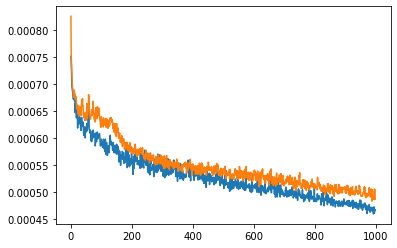

In [6]:
import matplotlib.pyplot as plt
plt.plot(Val_loss);
plt.plot(Train_loss);

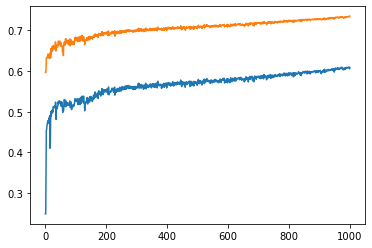

In [7]:
plt.plot(F1score)
plt.plot(Accuracy)

In [8]:
import pickle
with open("Val_loss_LSTM", "wb") as fp:   #Pickling
    pickle.dump(Val_loss, fp)
with open("Val_loss_LSTM", "rb") as fp:   # Unpickling
    Val_loss_ALSTM = pickle.load(fp)
    
with open("Train_loss_LSTM", "wb") as fp:   #Pickling
    pickle.dump(Train_loss, fp)
with open("Train_loss_LSTM", "rb") as fp:   # Unpickling
    Train_loss_ALSTM = pickle.load(fp)
    
with open("Accuracy_LSTM", "wb") as fp:   #Pickling
    pickle.dump(Accuracy, fp)
with open("Accuracy_LSTM", "rb") as fp:   # Unpickling
    Accuracy_ALSTM = pickle.load(fp)
    
with open("F1_LSTM", "wb") as fp:   #Pickling
    pickle.dump(F1score, fp)
with open("F1_LSTM", "rb") as fp:   # Unpickling
    F1_ALSTM = pickle.load(fp)

In [9]:

with open("Val_loss_Trans", "rb") as fp:   # Unpickling
    Val_loss_Trans = pickle.load(fp)

with open("Train_loss_Trans", "rb") as fp:   # Unpickling
    Train_loss_Trans = pickle.load(fp)
    

with open("Accuracy_Trans", "rb") as fp:   # Unpickling
    Accuracy_Trans = pickle.load(fp)
    

with open("F1_Trans", "rb") as fp:   # Unpickling
    F1_Trans = pickle.load(fp)

In [12]:
with open("Val_loss_ALSTM", "rb") as fp:   # Unpickling
    Val_loss_ALSTM = pickle.load(fp)

with open("Train_loss_ALSTM", "rb") as fp:   # Unpickling
    Train_loss_ALSTM = pickle.load(fp)
    

with open("Accuracy_ALSTM", "rb") as fp:   # Unpickling
    Accuracy_ALSTM = pickle.load(fp)
    

with open("F1_ALSTM", "rb") as fp:   # Unpickling
    F1_ALSTM = pickle.load(fp)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


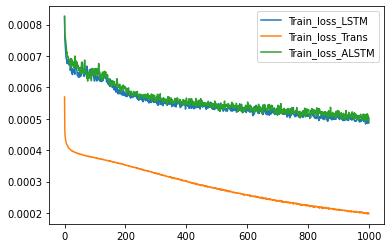

In [18]:
fig,ax=plt.subplots()
# ax.plot(Val_loss);
ax.plot(Train_loss);

# ax.plot(Val_loss_Trans);
ax.plot(Train_loss_Trans);
# ax.plot(Val_loss_ALSTM);
ax.plot(Train_loss_ALSTM);
ax.legend(["Train_loss_LSTM","Train_loss_Trans","Train_loss_ALSTM"])
fig.savefig('Loss.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


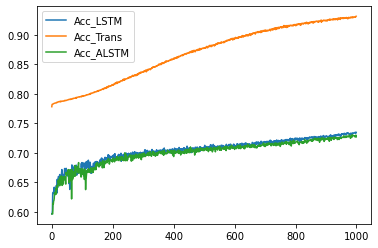

In [15]:
plt.plot(Accuracy);
# plt.plot(F1score);

plt.plot(Accuracy_Trans);
plt.plot(Accuracy_ALSTM);
# plt.plot(F1_Trans);
plt.legend(["Acc_LSTM","Acc_Trans","Acc_ALSTM"])
plt.savefig('Accuracy.eps')



for MBR_NO,BRN_NO in mbrnlist:
    if featnorm==True:
        Data_train = load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'norm_train.npy',allow_pickle=True)
        Data_test =  load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'norm_test.npy',allow_pickle=True)
    else:
        Data_train = load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'train.npy',allow_pickle=True)
        Data_test =  load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'test.npy',allow_pickle=True)

    Xtrain_data,Ytrain_data,Xtest_data,Ytest_data = Data_load(Data_train,Data_test)
    torch.manual_seed(0)

    SRC_VOCAB_SIZE = Xtrain_data.shape[1]


    lstm = RNNModel(rnn_type='LSTM',ntoken=SRC_VOCAB_SIZE,ninp=EMB_SIZE,nhid=FFN_HID_DIM,nlayers=NUM_LAYERS,proj_size=TGT_VOCAB_SIZE,
                    attention_width=38)
    summary = SummaryWriter()
    for p in lstm.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    lstm = lstm.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

    NUM_EPOCHS = 1000
    best_val_loss=100000000
    for epoch in range(1, NUM_EPOCHS+1):
        start_time = timer()
        train_loss,_ = train_epoch_lstm(lstm, optimizer,Xtrain_data,Ytrain_data,loss_fn,device,BATCH_SIZE,bptt)
        end_time = timer()
        val_loss,acc,prec,reca,f1sc,confusion = evaluate_lstm(lstm,Xtrain_data,Ytrain_data,loss_fn,device,BATCH_SIZE,bptt)
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_confusion=confusion
            best_acc=acc
            best_prec=prec
            best_reca=reca
            best_f1sc=f1sc
            best_model = lstm
        summary.add_scalar('val loss', val_loss, epoch)
        summary.add_scalar('total loss', train_loss, epoch)
        summary.add_scalar('f1 score', f1sc, epoch)
        summary.add_scalar('Accuracy', acc, epoch)
    now = datetime.now()
    now.strftime("%m/%d/%Y, %H:%M:%S")

    date_time = now.strftime("%m_%d_%Y")

    PATH='best_model_alstm_seq_'+date_time+'_'+str(MBR_NO)+'_'+str(BRN_NO)
#     if featnorm==True:
#         torch.save(best_model.state_dict(), PATH+'norm')
#     else:
#         torch.save(best_model.state_dict(), PATH)
    if featnorm==True:
        file_name='results/result_ALSTM_'+date_time+'_norm.txt'
    else:
        file_name='results/result_ALSTM_'+date_time+'.txt'
    text_to_append=PATH+'\t'+"Acc:"+str(best_acc)+'\t'+"prec:"+str(best_prec)+'\t'+"recall:"+str(best_reca)+'\t'+"f1sc:"+str(best_f1sc)
    print(text_to_append)
    with open(file_name, "a+") as file_object:
        # Move read cursor to the start of file.
        file_object.seek(0)
        # If file is not empty then append '\n'
        data = file_object.read(100)
        if len(data) > 0:
            file_object.write("\n")
        # Append text at the end of file
        file_object.write(text_to_append)